Exercise for Unit 6 

LIBUNA | BSCS 3B - AI

AI was used to help generate the codebase


In [31]:
# Lib imports
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt

CHIHUAHUA VS MUFFIN IMAGE CLASSIFIER

Dataset can be retrieved from: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification


In [3]:
# DATASET DIRECTORY CONFIGURATION
# Ensure folders match the local directory structure.
train_dir = "train"
test_dir = "test"

In [4]:
# IMAGE PARAMETERS
# Used to resize the input images, also will determine the input size of your input layer.
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [5]:
# DATA PREPROCESSING & AUGMENTATION
# Augmentation helps reduce overfitting and improve generalization.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.12,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 3788 images belonging to 2 classes.
Found 945 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [6]:
# IMPROVED CNN MODEL ARCHITECTURE

# Some modifications are applied
tf.keras.backend.clear_session()
initial_learning_rate = 1e-3
l2_reg = regularizers.l2(1e-4)

def conv_block(filters):
    return [
        layers.Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.Activation('relu')
    ]

model_layers = [layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))]
model_layers += conv_block(32)
model_layers += [layers.MaxPooling2D(2, 2), layers.Dropout(0.2)]
model_layers += conv_block(64)
model_layers += [layers.MaxPooling2D(2, 2), layers.Dropout(0.3)]
model_layers += conv_block(128)
model_layers += [layers.MaxPooling2D(2, 2), layers.Dropout(0.4)]
model_layers += [
    layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
]

model = models.Sequential(model_layers)

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)

In [7]:
# Configure the model optimizers, loss function, and metrics
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [8]:
# CALLBACKS FOR TRAINING
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.005,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    )
]

In [9]:
# TRAINING THE CNN
initial_epochs = 40
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator,
    callbacks=callbacks
)

history_history = {k: list(v) for k, v in history.history.items()}
best_val_acc = max(history_history.get('val_accuracy', [0.0]))
print(f"Best validation accuracy after initial training: {best_val_acc:.4f}")

if best_val_acc < 0.90:
    print("Validation accuracy below target. Continuing training with lowered learning rate...")
    model.optimizer.learning_rate.assign(initial_learning_rate * 0.2)
    extended_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            min_delta=0.003,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        )
    ]
    extra_epochs = 20
    extra_history = model.fit(
        train_generator,
        epochs=extra_epochs,
        validation_data=val_generator,
        callbacks=extended_callbacks
    )
    for key, values in extra_history.history.items():
        history_history[key] = history_history.get(key, []) + list(values)
    best_val_acc = max(history_history.get('val_accuracy', [best_val_acc]))
    print(f"Best validation accuracy after extended training: {best_val_acc:.4f}")

Epoch 1/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.7223 - loss: 0.7573 - val_accuracy: 0.5407 - val_loss: 1.1173 - learning_rate: 0.0010
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.8076 - loss: 0.5837 - val_accuracy: 0.5407 - val_loss: 1.3371 - learning_rate: 0.0010
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.8300 - loss: 0.5432 - val_accuracy: 0.5407 - val_loss: 1.3403 - learning_rate: 0.0010
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8374 - loss: 0.5177 - val_accuracy: 0.8571 - val_loss: 0.4783 - learning_rate: 0.0010
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.8567 - loss: 0.4934 - val_accuracy: 0.9048 - val_loss: 0.4029 - learning_rate: 0.0010
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.8635 - loss: 0.4714 - val_accuracy: 0.8783 - val_loss: 0.4393 - learning_rate: 0.0010
Epoch 7/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.8580 - loss: 0.

A.	(5 points) Accuracy

In [23]:
# EVALUATE THE MODEL
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.9113 - loss: 0.3616
Test Accuracy: 0.9113175868988037


C.	(10 points) Rename the trained CNN model to “exercise_6_trained_model_improved.h5” 

In [24]:
# SAVE THE MODEL
model.save('exercise_6_trained_model_improved.h5')

In [36]:
# SIMPLE INFERENCE SCRIPT
from tensorflow.keras.preprocessing import image


def predict_image(img_path, model_path='exercise_6_trained_model_improved.h5'):
    model = tf.keras.models.load_model(model_path)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prob_muffin = float(model.predict(img_array, verbose=0)[0, 0])
    label = "Muffin" if prob_muffin >= 0.5 else "Chihuahua"
    confidence = prob_muffin if label == "Muffin" else 1 - prob_muffin
    image_name = os.path.basename(img_path)
    print(f"Image: {image_name} -> Prediction: {label} (confidence: {confidence:.2f})")
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label} ({confidence:.2f})")
    plt.show()
    return label, confidence
   

B.	(10 points) Run 1 and 2’s prediction and confidence

Image: run1.jpg -> Prediction: Chihuahua (confidence: 0.95)


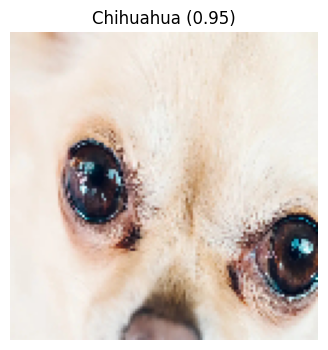

Image: run2.jpg -> Prediction: Muffin (confidence: 0.71)


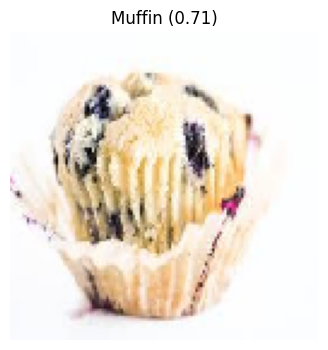

('Muffin', 0.7127320766448975)

In [37]:
# Example usage:
predict_image("run1.jpg")
predict_image("run2.jpg")

----------------------------------------------------------------------------------------------------------------

3.	(25 points) Look for another dataset and apply it to the CNN architecture and retrain the CNN model, this time name the trained CNN model to “exercise_6_custom_lastname.h5

WOLF VS HUSKY IMAGE CLASSIFER

Datasets can be retrieved from: https://www.kaggle.com/datasets/karimalagamy/wolf-husky-classifier-dataset

In [ ]:
# NEW DATASET DIRECTORY CONFIGURATION
train_dir = "train2"
test_dir = "test2"

In [39]:
# RETRAINING THE CNN FOR HUSKY VS WOLF
initial_epochs = 40
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator,
    callbacks=callbacks
)

history_history = {k: list(v) for k, v in history.history.items()}
best_val_acc = max(history_history.get('val_accuracy', [0.0]))
print(f"Best validation accuracy after initial training: {best_val_acc:.4f}")

if best_val_acc < 0.90:
    print("Validation accuracy below target. Continuing training with lowered learning rate...")
    model.optimizer.learning_rate.assign(initial_learning_rate * 0.2)
    extended_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            min_delta=0.003,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        )
    ]
    extra_epochs = 20
    extra_history = model.fit(
        train_generator,
        epochs=extra_epochs,
        validation_data=val_generator,
        callbacks=extended_callbacks
    )
    for key, values in extra_history.history.items():
        history_history[key] = history_history.get(key, []) + list(values)
    best_val_acc = max(history_history.get('val_accuracy', [best_val_acc]))
    print(f"Best validation accuracy after extended training: {best_val_acc:.4f}")

Epoch 1/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9234 - loss: 0.3374 - val_accuracy: 0.9503 - val_loss: 0.2766 - learning_rate: 6.2500e-05
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.9279 - loss: 0.3318 - val_accuracy: 0.9651 - val_loss: 0.2599 - learning_rate: 6.2500e-05
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9205 - loss: 0.3432 - val_accuracy: 0.9587 - val_loss: 0.2658 - learning_rate: 6.2500e-05
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.9282 - loss: 0.3384 - val_accuracy: 0.9566 - val_loss: 0.2669 - learning_rate: 6.2500e-05
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9308 - loss: 0.3388
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
119/119 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9314 - loss: 0.3347 - val_accuracy: 0.9418 - val_loss: 0.2924 - learning_rate: 6.2500e-05
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 

In [ ]:
# SAVE THE CUSTOM MODEL
model.save('exercise_6_custom_libuna.h5')

4.	(50 points) Using your chosen dataset, utilize a CNN architecture of Resnet

In [44]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 5

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    "train2",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)
test_gen = test_datagen.flow_from_directory(
    "test2",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

base_model = ResNet50(weights="imagenet", include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(train_gen, epochs=EPOCHS, validation_data=test_gen)
model.save("wolf_vs_husky_resnet.h5")
print("Saved wolf_vs_husky_resnet.h5")


Found 100 images belonging to 2 classes.


Found 50 images belonging to 1 classes.
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8700 - loss: 0.4642 - val_accuracy: 0.7800 - val_loss: 0.5083
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9600 - loss: 0.2339 - val_accuracy: 0.9600 - val_loss: 0.2086
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9900 - loss: 0.0989 - val_accuracy: 0.9800 - val_loss: 0.1138
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 1.0000 - loss: 0.0496 - val_accuracy: 0.9800 - val_loss: 0.0797
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0343 - val_accuracy: 0.9800 - val_loss: 0.0550


Saved wolf_vs_husky_resnet.h5


In [48]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

IMG_SIZE = 224
BATCH_SIZE = 16

# Load model
model = load_model("wolf_vs_husky_resnet.h5")
print("Model loaded.")

# Test generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    "test2",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predictions
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype(int).ravel()

true_labels = test_generator.classes
class_names = ["husky", "wolf"]  # must match folder names

print("\nClassification Report:")
print(classification_report(
    true_labels,
    pred_labels,
    labels=[0, 1],
    target_names=class_names
))




Model loaded.
Found 100 images belonging to 2 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 723ms/step - accuracy: 0.9900 - loss: 0.0348
Test Loss: 0.0348
Test Accuracy: 99.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 

Classification Report:
              precision    recall  f1-score   support

       husky       1.00      0.98      0.99        50
        wolf       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

